## Importing libraries

For any issues running these modules, use python -m pip install -r requirements.txt

In [1]:
import librosa
import pandas as pd
import numpy as np
import sklearn

import os

import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")

## Load data, separate into train/test

In [2]:
from fractions import Fraction
import random

path = "./data/audio_speech_actors_01-24/"
actors = os.listdir(path)

# We need to categorize the data files according to their emotion. Since the dataset is labelled by emotion (which is encoded into their filenames), we need to break that down
# Filename identifiers:
# Modality (01 = full-AV, 02 = video-only, 03 = audio-only).
#
# Vocal channel (01 = speech, 02 = song).
#
# Emotion (01 = neutral, 02 = calm, 03 = happy, 04 = sad, 05 = angry, 06 = fearful, 07 = disgust, 08 = surprised).
#
# Emotional intensity (01 = normal, 02 = strong). NOTE: There is no strong intensity for the 'neutral' emotion.
#
# Statement (01 = "Kids are talking by the door", 02 = "Dogs are sitting by the door").
#
# Repetition (01 = 1st repetition, 02 = 2nd repetition).
#
# Actor (01 to 24. Odd numbered actors are male, even numbered actors are female).

# We are only focusing on the emotion, so we categorize by the third number (01-08)
# according to the dataset's site
mapping = {1:"neutral", 2:"calm", 3:"happy", 4:"sad", 5:"angry", 6:"fearful", 7:"disgust", 8:"surprised"}

def load_data(path, return_train_test=False, test_percentage=0.20):
    # 1 slot for each of the emotions
    emot = []
    paths = []
    train_test_labels = []
    
    # Custom making our train/test split
    test_threshold = int(len(os.listdir(path)) * test_percentage + 1)    # (At least) 20% of data reserved for testing (important that we do this by actor to prevent data leakage)
    print("Test data is {:0.2f}% of the overall data".format(1 / (len(os.listdir(path))/test_threshold)))
    
    # Make a list of actors so we can shuffle order (last few actors will not always be test data each time we load data)
    actors = []
    for directory in os.listdir(path):
        actors.append(directory)
    random.shuffle(actors)
    
    count = 0
    data_label = "test"
    for directory in actors:
        count += 1
        if (count == test_threshold):
            data_label = "train"
        files = os.path.join(path, directory)
        for file in os.listdir(files):
            em_num = int(file.split("-")[2])
            emot.append(em_num)
            train_test_labels.append(data_label)
            paths.append(path + directory + "/" + file)
    
    tts = pd.DataFrame(train_test_labels, columns=["train_test"])
    ems = pd.DataFrame(emot, columns=['emotion']).replace(mapping)
    pths = pd.DataFrame(paths, columns = ["path"])
    data_file = pd.concat(
        [
            tts.reset_index(drop=True),
            ems.reset_index(drop=True),
            pths.reset_index(drop=True)
        ],
        axis=1,
    )
    
    if return_train_test:
        return get_train_test(data_file)
    return data_file

def get_train_test(data):
    grouped = data.groupby(data.train_test)
    train = grouped.get_group("train")
    test = grouped.get_group("test")
    return train, test

print("--- Building Train/Test Data ---")
data = load_data(path)
train, test = get_train_test(data)
train_size = train.train_test.value_counts().train
test_size = test.train_test.value_counts().test
print("Train has", train_size, "files.")
print("Test has", test_size, "files.")

ratio = Fraction(train_size, test_size)
print("Split is", str(ratio.numerator)+":"+str(ratio.denominator), "train:test")

--- Building Train/Test Data ---
Test data is 0.21% of the overall data
Train has 1200 files.
Test has 240 files.
Split is 5:1 train:test


## Extract data

In [3]:
import numpy as np

X = []
y = []

# for m in mapping:
#     for i in train[m]:
#         X.append(i)
#         y.append(m)

def gen_mfccs(data, NUM_MFCCs=13):
    mfccs = pd.DataFrame(columns=['mfccs'])
    
    # Get mfccs from each audio file
    count=0
    for i, j in data.iterrows():
        for item in j.items():
            if item[0] == 'path':
                # Sample rate and duration taken from the kaggle dataset description
                file, sample_rate = librosa.load(item[1], res_type='kaiser_fast',duration=2.5,sr=22050*2,offset=0.5)
                sample_rate = np.array(sample_rate)
                mfcc = np.mean(librosa.feature.mfcc(y=file, sr=sample_rate, n_mfcc=NUM_MFCCs), axis=0)
                mfccs.loc[count] = [mfcc]
                count+=1
                break
    
    # Gen list of mfccs as a dataframe to **manually** concatenate onto data
#     mfccs = pd.DataFrame(mfccs, columns = [("mfcc_" + str(num)) for num in range(len(mfccs[0]))])
#     data = pd.concat(
#         [
#             data.reset_index(drop=True),
#             mfccs.reset_index(drop=True)
#         ],
#         axis=1
#     )

    # Add on these mfccs to the data DataFrame
    return pd.concat([data.reset_index(drop=True), pd.DataFrame(mfccs["mfccs"].values.tolist())], axis=1)
        
data = gen_mfccs(data)
data = data.fillna(0)
train, test = get_train_test(data)

# Save train + test DataFrame file as a csv
data.to_csv("extracted_data.csv",index=False)

In [4]:
def get_x_y(data):
    rev_mapping = {emotion: num for num, emotion in mapping.items()}
    x, y = [], []
    for i, j in data.iterrows():
        col = (label for label in j.items() if label[0] == 'emotion')
        for item in col:
            y.append(rev_mapping[item[1]])
        count = 0
        xs = []
        for k in j.items():
            if count > 5:
                xs.append(k[1])
            count += 1
        x.append(xs)
    return x, y

# The numbered columns are mfccs
print(train)
train_x, train_y = get_x_y(train)
test_x, test_y = get_x_y(test)

     train_test    emotion                                               path  \
240       train  surprised  ./data/audio_speech_actors_01-24/Actor_09/03-0...   
241       train  surprised  ./data/audio_speech_actors_01-24/Actor_09/03-0...   
242       train      angry  ./data/audio_speech_actors_01-24/Actor_09/03-0...   
243       train    fearful  ./data/audio_speech_actors_01-24/Actor_09/03-0...   
244       train    fearful  ./data/audio_speech_actors_01-24/Actor_09/03-0...   
...         ...        ...                                                ...   
1435      train       calm  ./data/audio_speech_actors_01-24/Actor_02/03-0...   
1436      train    neutral  ./data/audio_speech_actors_01-24/Actor_02/03-0...   
1437      train       calm  ./data/audio_speech_actors_01-24/Actor_02/03-0...   
1438      train      happy  ./data/audio_speech_actors_01-24/Actor_02/03-0...   
1439      train      happy  ./data/audio_speech_actors_01-24/Actor_02/03-0...   

              0          1 

## Baselines

In [5]:
from sklearn.dummy import DummyClassifier

# train a dummy classifier to make predictions based on the most_frequent class value
frequent_dummy_classifier = DummyClassifier(strategy="most_frequent")
frequent_dummy_classifier.fit(train_x, train_y)

print("Highest frequency baseline:", frequent_dummy_classifier.score(test_x, test_y))

# train a dummy classifier to make predictions based on the class values
stratified_dummy_classifier = DummyClassifier(strategy="stratified")
stratified_dummy_classifier.fit(train_x,train_y)

print("Random baseline", stratified_dummy_classifier.score(test_x, test_y))

# train a dummy classifier to make predictions based on uniform selection
uniform_dummy_classifier = DummyClassifier(strategy="uniform")
uniform_dummy_classifier.fit(train_x,train_y)

print("Random uniform baseline", uniform_dummy_classifier.score(test_x, test_y))

Highest frequency baseline: 0.13333333333333333
Random baseline 0.15833333333333333
Random uniform baseline 0.1375


## Data preparation

If we want to transform the data in any way, we can do it here.

In [7]:
train_length = len(train_x[0])
train_x = np.array(train_x).reshape(-1,train_length,1)
print(np.shape(train_x))
print(train_x[0])
print()


test_length = len(test_x[0])
test_x = np.array(test_x).reshape(-1,test_length,1)
print(np.shape(test_x))
print(test_x[0])


# from sklearn.preprocessing import LabelEncoder
# le = LabelEncoder()


# # 
# # Generates an int for each label
# y=le.fit_transform(labels)

# # Prints out each date with its int mapping
# for c in list(le.classes_):
#     print(le.transform([c])[0], c)

(1200, 213, 1)
[[-55.26924896]
 [-56.1364975 ]
 [-57.63772202]
 [-58.21823502]
 [-58.39059067]
 [-58.59286118]
 [-58.59286118]
 [-58.59286118]
 [-58.59286118]
 [-58.59286118]
 [-58.59286118]
 [-58.59286118]
 [-58.57069397]
 [-58.59286118]
 [-58.53364944]
 [-57.45916367]
 [-58.20681381]
 [-58.59286118]
 [-58.54962158]
 [-58.44428253]
 [-58.59286118]
 [-58.34177017]
 [-58.17399597]
 [-58.59286118]
 [-58.59286118]
 [-58.59286118]
 [-58.59286118]
 [-58.59286118]
 [-58.59286118]
 [-58.59286118]
 [-58.59286118]
 [-56.78277206]
 [-52.91753769]
 [-51.94740677]
 [-51.11194611]
 [-50.75716019]
 [-53.61134338]
 [-53.16996002]
 [-53.41305923]
 [-49.80541992]
 [-44.81842804]
 [-36.13505936]
 [-31.42490387]
 [-29.70433235]
 [-28.17225075]
 [-21.76544189]
 [-20.44127655]
 [-20.49786377]
 [-21.24540138]
 [-22.37733841]
 [-24.93726921]
 [-24.83314705]
 [-25.29724884]
 [-27.66734695]
 [-30.3040905 ]
 [-30.83553696]
 [-30.53357124]
 [-30.1076622 ]
 [-28.45379639]
 [-27.68619919]
 [-26.11016846]
 [-24.068

In [8]:
import keras
from keras.utils import np_utils

labels=["neutral", "calm", "happy", "sad", "angry", "fearful", "disgust", "surprised"]

train_y = [val-1 for val in train_y]
train_y = [int(val) for val in train_y]
print(train_y[0], labels[0])
train_y=np_utils.to_categorical(train_y, num_classes=len(labels), dtype=np.int32)
print(train_y[0], labels[0])

test_y = [val-1 for val in test_y]
print(test_y[0], labels[0])
test_y=np_utils.to_categorical(test_y, num_classes=len(labels), dtype=np.int32)
print(test_y[0], labels[0])

7 neutral
[0 0 0 0 0 0 0 1] neutral
7 neutral
[0 0 0 0 0 0 0 1] neutral


## Initializing the model

In [335]:
from keras.layers import Dense, Dropout, Flatten, Conv1D, Input, MaxPooling1D, BatchNormalization
from keras.models import Model
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras import backend as K
from keras.regularizers import l2

In [339]:
K.clear_session()

inputs = Input(shape=(train_length,1))

#First Conv1D layer
conv = Conv1D(8, 13, padding='valid', activation='relu', strides=1, kernel_regularizer=l2(0.01), bias_regularizer=l2(0.01))(inputs)
conv = BatchNormalization()(conv)
conv = MaxPooling1D(3)(conv)
conv = Dropout(0.3)(conv)

#Second Conv1D layer
conv = Conv1D(16, 11, padding='valid', activation='relu', strides=1, kernel_regularizer=l2(0.01), bias_regularizer=l2(0.01))(conv)
conv = MaxPooling1D(3)(conv)
conv = Dropout(0.3)(conv)

#Third Conv1D layer
conv = Conv1D(32, 9, padding='valid', activation='relu', strides=1, kernel_regularizer=l2(0.01), bias_regularizer=l2(0.01))(conv)
conv = MaxPooling1D(3)(conv)
conv = Dropout(0.3)(conv)

#Flatten layer
conv = Flatten()(conv)

#Dense Layer 1
conv = Dense(64, activation='relu', kernel_regularizer=l2(0.01), bias_regularizer=l2(0.01))(conv)
conv = Dropout(0.3)(conv)

# conv = BatchNormalization()(conv)

# Output layer
outputs = Dense(len(labels), activation='softmax')(conv)

model = Model(inputs, outputs)
model.summary()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 213, 1)]          0         
_________________________________________________________________
conv1d (Conv1D)              (None, 201, 8)            112       
_________________________________________________________________
batch_normalization (BatchNo (None, 201, 8)            32        
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 67, 8)             0         
_________________________________________________________________
dropout (Dropout)            (None, 67, 8)             0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 57, 16)            1424      
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 19, 16)           

In [340]:
optimizer = keras.optimizers.Adam(lr=0.0001)
model.compile(loss='categorical_crossentropy',optimizer=optimizer,metrics=['accuracy'])
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=20, min_delta=0.0001) 
mc = ModelCheckpoint('best_model.hdf5', monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')

## Training the model

In [341]:
history=model.fit(np.array(train_x), np.array(train_y), epochs=500, callbacks=[ mc], batch_size=32, validation_data=(np.array(test_x),np.array(test_y)))
print("MODEL TRAINING COMPLETE!")

Epoch 1/500
30/38 [======================>.......] - ETA: 0s - loss: 3.4769 - accuracy: 0.1135
Epoch 00001: val_accuracy improved from -inf to 0.10417, saving model to best_model.hdf5
38/38 [==============================] - 0s 11ms/step - loss: 3.4507 - accuracy: 0.1192 - val_loss: 3.2794 - val_accuracy: 0.1042
Epoch 2/500
28/38 [=====================>........] - ETA: 0s - loss: 3.3094 - accuracy: 0.1228
Epoch 00002: val_accuracy did not improve from 0.10417
38/38 [==============================] - 0s 6ms/step - loss: 3.3068 - accuracy: 0.1250 - val_loss: 3.1833 - val_accuracy: 0.0958
Epoch 3/500
33/38 [=========================>....] - ETA: 0s - loss: 3.2413 - accuracy: 0.1364
Epoch 00003: val_accuracy improved from 0.10417 to 0.12500, saving model to best_model.hdf5
38/38 [==============================] - 0s 6ms/step - loss: 3.2368 - accuracy: 0.1367 - val_loss: 3.1426 - val_accuracy: 0.1250
Epoch 4/500
31/38 [=======================>......] - ETA: 0s - loss: 3.1982 - accuracy: 0.1

31/38 [=======================>......] - ETA: 0s - loss: 2.7330 - accuracy: 0.1885
Epoch 00029: val_accuracy did not improve from 0.22083
38/38 [==============================] - 0s 6ms/step - loss: 2.7242 - accuracy: 0.1900 - val_loss: 2.7124 - val_accuracy: 0.2125
Epoch 30/500
32/38 [========================>.....] - ETA: 0s - loss: 2.7103 - accuracy: 0.1836
Epoch 00030: val_accuracy did not improve from 0.22083
38/38 [==============================] - 0s 6ms/step - loss: 2.7137 - accuracy: 0.1867 - val_loss: 2.6989 - val_accuracy: 0.2167
Epoch 31/500
34/38 [=========================>....] - ETA: 0s - loss: 2.7030 - accuracy: 0.1884
Epoch 00031: val_accuracy did not improve from 0.22083
38/38 [==============================] - 0s 5ms/step - loss: 2.6999 - accuracy: 0.1875 - val_loss: 2.6856 - val_accuracy: 0.2000
Epoch 32/500
32/38 [========================>.....] - ETA: 0s - loss: 2.6812 - accuracy: 0.1680
Epoch 00032: val_accuracy did not improve from 0.22083
38/38 [===============

38/38 [==============================] - ETA: 0s - loss: 2.3952 - accuracy: 0.2233
Epoch 00058: val_accuracy improved from 0.22917 to 0.23333, saving model to best_model.hdf5
38/38 [==============================] - 0s 9ms/step - loss: 2.3952 - accuracy: 0.2233 - val_loss: 2.4043 - val_accuracy: 0.2333
Epoch 59/500
32/38 [========================>.....] - ETA: 0s - loss: 2.3793 - accuracy: 0.2461
Epoch 00059: val_accuracy improved from 0.23333 to 0.24583, saving model to best_model.hdf5
38/38 [==============================] - 0s 8ms/step - loss: 2.3790 - accuracy: 0.2500 - val_loss: 2.3968 - val_accuracy: 0.2458
Epoch 60/500
31/38 [=======================>......] - ETA: 0s - loss: 2.3702 - accuracy: 0.2389
Epoch 00060: val_accuracy improved from 0.24583 to 0.25833, saving model to best_model.hdf5
38/38 [==============================] - 0s 7ms/step - loss: 2.3780 - accuracy: 0.2317 - val_loss: 2.3889 - val_accuracy: 0.2583
Epoch 61/500
31/38 [=======================>......] - ETA: 0s 

Epoch 87/500
34/38 [=========================>....] - ETA: 0s - loss: 2.1945 - accuracy: 0.2638
Epoch 00087: val_accuracy improved from 0.26667 to 0.27083, saving model to best_model.hdf5
38/38 [==============================] - 0s 6ms/step - loss: 2.1879 - accuracy: 0.2675 - val_loss: 2.2203 - val_accuracy: 0.2708
Epoch 88/500
34/38 [=========================>....] - ETA: 0s - loss: 2.1661 - accuracy: 0.2619
Epoch 00088: val_accuracy did not improve from 0.27083
38/38 [==============================] - 0s 6ms/step - loss: 2.1647 - accuracy: 0.2608 - val_loss: 2.2118 - val_accuracy: 0.2625
Epoch 89/500
33/38 [=========================>....] - ETA: 0s - loss: 2.1702 - accuracy: 0.2623
Epoch 00089: val_accuracy did not improve from 0.27083
38/38 [==============================] - 0s 5ms/step - loss: 2.1795 - accuracy: 0.2567 - val_loss: 2.2080 - val_accuracy: 0.2625
Epoch 90/500
30/38 [======================>.......] - ETA: 0s - loss: 2.1659 - accuracy: 0.2562
Epoch 00090: val_accuracy d

Epoch 116/500
34/38 [=========================>....] - ETA: 0s - loss: 2.0347 - accuracy: 0.3070
Epoch 00116: val_accuracy did not improve from 0.27917
38/38 [==============================] - 0s 5ms/step - loss: 2.0365 - accuracy: 0.3042 - val_loss: 2.0951 - val_accuracy: 0.2667
Epoch 117/500
31/38 [=======================>......] - ETA: 0s - loss: 2.0541 - accuracy: 0.2692
Epoch 00117: val_accuracy did not improve from 0.27917
38/38 [==============================] - 0s 6ms/step - loss: 2.0427 - accuracy: 0.2792 - val_loss: 2.0968 - val_accuracy: 0.2667
Epoch 118/500
31/38 [=======================>......] - ETA: 0s - loss: 2.0335 - accuracy: 0.2873
Epoch 00118: val_accuracy did not improve from 0.27917
38/38 [==============================] - 0s 6ms/step - loss: 2.0406 - accuracy: 0.2858 - val_loss: 2.0911 - val_accuracy: 0.2667
Epoch 119/500
34/38 [=========================>....] - ETA: 0s - loss: 2.0407 - accuracy: 0.3051
Epoch 00119: val_accuracy did not improve from 0.27917
38/38

Epoch 145/500
33/38 [=========================>....] - ETA: 0s - loss: 1.9546 - accuracy: 0.3229
Epoch 00145: val_accuracy did not improve from 0.30000
38/38 [==============================] - 0s 6ms/step - loss: 1.9523 - accuracy: 0.3225 - val_loss: 2.0328 - val_accuracy: 0.2750
Epoch 146/500
31/38 [=======================>......] - ETA: 0s - loss: 1.9571 - accuracy: 0.3105
Epoch 00146: val_accuracy did not improve from 0.30000
38/38 [==============================] - 0s 6ms/step - loss: 1.9560 - accuracy: 0.3050 - val_loss: 2.0346 - val_accuracy: 0.2708
Epoch 147/500
34/38 [=========================>....] - ETA: 0s - loss: 1.9692 - accuracy: 0.3134
Epoch 00147: val_accuracy did not improve from 0.30000
38/38 [==============================] - 0s 5ms/step - loss: 1.9609 - accuracy: 0.3183 - val_loss: 2.0314 - val_accuracy: 0.2875
Epoch 148/500
34/38 [=========================>....] - ETA: 0s - loss: 1.9807 - accuracy: 0.3051
Epoch 00148: val_accuracy did not improve from 0.30000
38/38

31/38 [=======================>......] - ETA: 0s - loss: 1.9163 - accuracy: 0.3034
Epoch 00174: val_accuracy did not improve from 0.30000
38/38 [==============================] - 0s 6ms/step - loss: 1.9074 - accuracy: 0.3208 - val_loss: 1.9774 - val_accuracy: 0.2917
Epoch 175/500
31/38 [=======================>......] - ETA: 0s - loss: 1.8859 - accuracy: 0.3397
Epoch 00175: val_accuracy did not improve from 0.30000
38/38 [==============================] - 0s 6ms/step - loss: 1.8929 - accuracy: 0.3350 - val_loss: 1.9805 - val_accuracy: 0.2875
Epoch 176/500
33/38 [=========================>....] - ETA: 0s - loss: 1.8979 - accuracy: 0.3172
Epoch 00176: val_accuracy did not improve from 0.30000
38/38 [==============================] - 0s 5ms/step - loss: 1.9029 - accuracy: 0.3192 - val_loss: 1.9753 - val_accuracy: 0.2833
Epoch 177/500
29/38 [=====================>........] - ETA: 0s - loss: 1.9150 - accuracy: 0.3254
Epoch 00177: val_accuracy did not improve from 0.30000
38/38 [============

Epoch 203/500
35/38 [==========================>...] - ETA: 0s - loss: 1.8789 - accuracy: 0.3357
Epoch 00203: val_accuracy did not improve from 0.31667
38/38 [==============================] - 0s 7ms/step - loss: 1.8698 - accuracy: 0.3375 - val_loss: 1.9432 - val_accuracy: 0.3083
Epoch 204/500
38/38 [==============================] - ETA: 0s - loss: 1.8544 - accuracy: 0.3308
Epoch 00204: val_accuracy did not improve from 0.31667
38/38 [==============================] - 0s 6ms/step - loss: 1.8544 - accuracy: 0.3308 - val_loss: 1.9457 - val_accuracy: 0.3125
Epoch 205/500
36/38 [===========================>..] - ETA: 0s - loss: 1.8632 - accuracy: 0.3368
Epoch 00205: val_accuracy did not improve from 0.31667
38/38 [==============================] - 0s 10ms/step - loss: 1.8661 - accuracy: 0.3350 - val_loss: 1.9499 - val_accuracy: 0.3042
Epoch 206/500
36/38 [===========================>..] - ETA: 0s - loss: 1.8762 - accuracy: 0.3342
Epoch 00206: val_accuracy did not improve from 0.31667
38/3

32/38 [========================>.....] - ETA: 0s - loss: 1.8165 - accuracy: 0.3555
Epoch 00232: val_accuracy did not improve from 0.31667
38/38 [==============================] - 0s 6ms/step - loss: 1.8164 - accuracy: 0.3608 - val_loss: 1.9257 - val_accuracy: 0.3125
Epoch 233/500
31/38 [=======================>......] - ETA: 0s - loss: 1.8068 - accuracy: 0.3417
Epoch 00233: val_accuracy did not improve from 0.31667
38/38 [==============================] - 0s 6ms/step - loss: 1.8205 - accuracy: 0.3417 - val_loss: 1.9235 - val_accuracy: 0.3000
Epoch 234/500
32/38 [========================>.....] - ETA: 0s - loss: 1.8374 - accuracy: 0.3311
Epoch 00234: val_accuracy did not improve from 0.31667
38/38 [==============================] - 0s 6ms/step - loss: 1.8206 - accuracy: 0.3500 - val_loss: 1.9195 - val_accuracy: 0.3125
Epoch 235/500
33/38 [=========================>....] - ETA: 0s - loss: 1.8082 - accuracy: 0.3636
Epoch 00235: val_accuracy did not improve from 0.31667
38/38 [============

32/38 [========================>.....] - ETA: 0s - loss: 1.8155 - accuracy: 0.3408
Epoch 00261: val_accuracy did not improve from 0.32917
38/38 [==============================] - 0s 5ms/step - loss: 1.8123 - accuracy: 0.3508 - val_loss: 1.9106 - val_accuracy: 0.3083
Epoch 262/500
34/38 [=========================>....] - ETA: 0s - loss: 1.7837 - accuracy: 0.3557
Epoch 00262: val_accuracy improved from 0.32917 to 0.33750, saving model to best_model.hdf5
38/38 [==============================] - 0s 6ms/step - loss: 1.7896 - accuracy: 0.3600 - val_loss: 1.9053 - val_accuracy: 0.3375
Epoch 263/500
33/38 [=========================>....] - ETA: 0s - loss: 1.7617 - accuracy: 0.3636
Epoch 00263: val_accuracy did not improve from 0.33750
38/38 [==============================] - 0s 5ms/step - loss: 1.7781 - accuracy: 0.3608 - val_loss: 1.9080 - val_accuracy: 0.3125
Epoch 264/500
32/38 [========================>.....] - ETA: 0s - loss: 1.7783 - accuracy: 0.3467
Epoch 00264: val_accuracy did not imp

Epoch 290/500
32/38 [========================>.....] - ETA: 0s - loss: 1.7717 - accuracy: 0.3760
Epoch 00290: val_accuracy did not improve from 0.34583
38/38 [==============================] - 0s 5ms/step - loss: 1.7532 - accuracy: 0.3875 - val_loss: 1.9052 - val_accuracy: 0.3333
Epoch 291/500
31/38 [=======================>......] - ETA: 0s - loss: 1.7486 - accuracy: 0.3730
Epoch 00291: val_accuracy did not improve from 0.34583
38/38 [==============================] - 0s 5ms/step - loss: 1.7542 - accuracy: 0.3717 - val_loss: 1.8912 - val_accuracy: 0.3375
Epoch 292/500
33/38 [=========================>....] - ETA: 0s - loss: 1.7558 - accuracy: 0.3703
Epoch 00292: val_accuracy did not improve from 0.34583
38/38 [==============================] - 0s 5ms/step - loss: 1.7603 - accuracy: 0.3700 - val_loss: 1.8927 - val_accuracy: 0.3333
Epoch 293/500
30/38 [======================>.......] - ETA: 0s - loss: 1.7712 - accuracy: 0.3792
Epoch 00293: val_accuracy did not improve from 0.34583
38/38

34/38 [=========================>....] - ETA: 0s - loss: 1.7447 - accuracy: 0.3888
Epoch 00319: val_accuracy did not improve from 0.35000
38/38 [==============================] - 0s 7ms/step - loss: 1.7416 - accuracy: 0.3933 - val_loss: 1.8769 - val_accuracy: 0.3458
Epoch 320/500
37/38 [============================>.] - ETA: 0s - loss: 1.7414 - accuracy: 0.3606
Epoch 00320: val_accuracy did not improve from 0.35000
38/38 [==============================] - 0s 6ms/step - loss: 1.7410 - accuracy: 0.3600 - val_loss: 1.8822 - val_accuracy: 0.3500
Epoch 321/500
33/38 [=========================>....] - ETA: 0s - loss: 1.7139 - accuracy: 0.3996
Epoch 00321: val_accuracy did not improve from 0.35000
38/38 [==============================] - 0s 7ms/step - loss: 1.7087 - accuracy: 0.4017 - val_loss: 1.8831 - val_accuracy: 0.3333
Epoch 322/500
34/38 [=========================>....] - ETA: 0s - loss: 1.7436 - accuracy: 0.3805
Epoch 00322: val_accuracy did not improve from 0.35000
38/38 [============

Epoch 348/500
33/38 [=========================>....] - ETA: 0s - loss: 1.6784 - accuracy: 0.3996
Epoch 00348: val_accuracy did not improve from 0.36250
38/38 [==============================] - 0s 5ms/step - loss: 1.6942 - accuracy: 0.3950 - val_loss: 1.8754 - val_accuracy: 0.3458
Epoch 349/500
30/38 [======================>.......] - ETA: 0s - loss: 1.7173 - accuracy: 0.3885
Epoch 00349: val_accuracy did not improve from 0.36250
38/38 [==============================] - 0s 6ms/step - loss: 1.7210 - accuracy: 0.3842 - val_loss: 1.8827 - val_accuracy: 0.3542
Epoch 350/500
32/38 [========================>.....] - ETA: 0s - loss: 1.7186 - accuracy: 0.3789
Epoch 00350: val_accuracy did not improve from 0.36250
38/38 [==============================] - 0s 6ms/step - loss: 1.7223 - accuracy: 0.3800 - val_loss: 1.8758 - val_accuracy: 0.3500
Epoch 351/500
33/38 [=========================>....] - ETA: 0s - loss: 1.7005 - accuracy: 0.3873
Epoch 00351: val_accuracy did not improve from 0.36250
38/38

29/38 [=====================>........] - ETA: 0s - loss: 1.6659 - accuracy: 0.4192
Epoch 00377: val_accuracy did not improve from 0.37083
38/38 [==============================] - 0s 6ms/step - loss: 1.6824 - accuracy: 0.4108 - val_loss: 1.8679 - val_accuracy: 0.3458
Epoch 378/500
37/38 [============================>.] - ETA: 0s - loss: 1.6928 - accuracy: 0.4029
Epoch 00378: val_accuracy did not improve from 0.37083
38/38 [==============================] - 0s 6ms/step - loss: 1.6977 - accuracy: 0.3983 - val_loss: 1.8737 - val_accuracy: 0.3625
Epoch 379/500
31/38 [=======================>......] - ETA: 0s - loss: 1.7099 - accuracy: 0.3851
Epoch 00379: val_accuracy did not improve from 0.37083
38/38 [==============================] - 0s 6ms/step - loss: 1.7011 - accuracy: 0.3850 - val_loss: 1.8746 - val_accuracy: 0.3375
Epoch 380/500
37/38 [============================>.] - ETA: 0s - loss: 1.7044 - accuracy: 0.3877
Epoch 00380: val_accuracy did not improve from 0.37083
38/38 [============

30/38 [======================>.......] - ETA: 0s - loss: 1.6868 - accuracy: 0.4000
Epoch 00406: val_accuracy did not improve from 0.37083
38/38 [==============================] - 0s 6ms/step - loss: 1.6876 - accuracy: 0.3983 - val_loss: 1.8719 - val_accuracy: 0.3375
Epoch 407/500
38/38 [==============================] - ETA: 0s - loss: 1.6809 - accuracy: 0.3892
Epoch 00407: val_accuracy did not improve from 0.37083
38/38 [==============================] - 0s 6ms/step - loss: 1.6809 - accuracy: 0.3892 - val_loss: 1.8695 - val_accuracy: 0.3292
Epoch 408/500
31/38 [=======================>......] - ETA: 0s - loss: 1.6766 - accuracy: 0.4133
Epoch 00408: val_accuracy did not improve from 0.37083
38/38 [==============================] - 0s 6ms/step - loss: 1.6725 - accuracy: 0.4125 - val_loss: 1.8637 - val_accuracy: 0.3500
Epoch 409/500
31/38 [=======================>......] - ETA: 0s - loss: 1.6736 - accuracy: 0.4113
Epoch 00409: val_accuracy did not improve from 0.37083
38/38 [============

32/38 [========================>.....] - ETA: 0s - loss: 1.6674 - accuracy: 0.3984
Epoch 00435: val_accuracy did not improve from 0.37083
38/38 [==============================] - 0s 6ms/step - loss: 1.6722 - accuracy: 0.3992 - val_loss: 1.8708 - val_accuracy: 0.3417
Epoch 436/500
30/38 [======================>.......] - ETA: 0s - loss: 1.6857 - accuracy: 0.4083
Epoch 00436: val_accuracy did not improve from 0.37083
38/38 [==============================] - 0s 6ms/step - loss: 1.6855 - accuracy: 0.3992 - val_loss: 1.8760 - val_accuracy: 0.3375
Epoch 437/500
31/38 [=======================>......] - ETA: 0s - loss: 1.6654 - accuracy: 0.4032
Epoch 00437: val_accuracy did not improve from 0.37083
38/38 [==============================] - 0s 6ms/step - loss: 1.6777 - accuracy: 0.3992 - val_loss: 1.8756 - val_accuracy: 0.3500
Epoch 438/500
37/38 [============================>.] - ETA: 0s - loss: 1.6988 - accuracy: 0.4012
Epoch 00438: val_accuracy did not improve from 0.37083
38/38 [============

31/38 [=======================>......] - ETA: 0s - loss: 1.6496 - accuracy: 0.4143
Epoch 00464: val_accuracy did not improve from 0.37500
38/38 [==============================] - 0s 6ms/step - loss: 1.6610 - accuracy: 0.4108 - val_loss: 1.8655 - val_accuracy: 0.3583
Epoch 465/500
31/38 [=======================>......] - ETA: 0s - loss: 1.6497 - accuracy: 0.4113
Epoch 00465: val_accuracy did not improve from 0.37500
38/38 [==============================] - 0s 6ms/step - loss: 1.6521 - accuracy: 0.4133 - val_loss: 1.8679 - val_accuracy: 0.3542
Epoch 466/500
31/38 [=======================>......] - ETA: 0s - loss: 1.6602 - accuracy: 0.3982
Epoch 00466: val_accuracy did not improve from 0.37500
38/38 [==============================] - 0s 6ms/step - loss: 1.6654 - accuracy: 0.3933 - val_loss: 1.8699 - val_accuracy: 0.3542
Epoch 467/500
30/38 [======================>.......] - ETA: 0s - loss: 1.6511 - accuracy: 0.4083
Epoch 00467: val_accuracy did not improve from 0.37500
38/38 [============

29/38 [=====================>........] - ETA: 0s - loss: 1.6617 - accuracy: 0.4106
Epoch 00493: val_accuracy did not improve from 0.37500
38/38 [==============================] - 0s 6ms/step - loss: 1.6531 - accuracy: 0.4175 - val_loss: 1.8714 - val_accuracy: 0.3333
Epoch 494/500
30/38 [======================>.......] - ETA: 0s - loss: 1.6267 - accuracy: 0.4167
Epoch 00494: val_accuracy did not improve from 0.37500
38/38 [==============================] - 0s 6ms/step - loss: 1.6444 - accuracy: 0.4158 - val_loss: 1.8685 - val_accuracy: 0.3458
Epoch 495/500
31/38 [=======================>......] - ETA: 0s - loss: 1.6255 - accuracy: 0.4183
Epoch 00495: val_accuracy did not improve from 0.37500
38/38 [==============================] - 0s 6ms/step - loss: 1.6141 - accuracy: 0.4275 - val_loss: 1.8636 - val_accuracy: 0.3458
Epoch 496/500
31/38 [=======================>......] - ETA: 0s - loss: 1.6228 - accuracy: 0.4335
Epoch 00496: val_accuracy did not improve from 0.37500
38/38 [============

## Post Visualization

Now we can take a look at how successful our model is and can easily find where overfitting takes place (if at all)

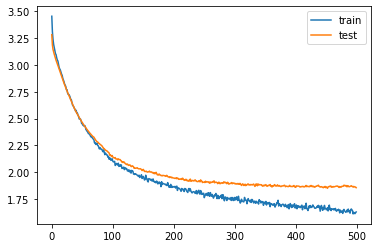

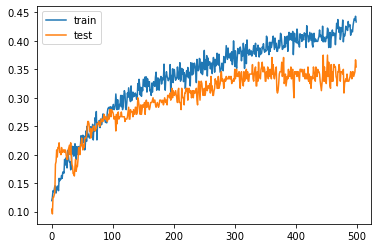

In [342]:
from matplotlib import pyplot as plt
plt.plot(history.history['loss'], label='train') 
plt.plot(history.history['val_loss'], label='test') 
plt.legend() 
plt.show()

plt.plot(history.history['accuracy'], label='train') 
plt.plot(history.history['val_accuracy'], label='test') 
plt.legend() 
plt.show()